# 0. Dataset Exploration

In this notebook, I'll be exploring methods for fraud detection.

This dataset was obtained here: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import itertools

from pprint import pprint
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import recall_score, precision_score, accuracy_score, make_scorer, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import fraudutils as futils
import warnings

warnings.filterwarnings(action='once')

%load_ext autoreload
%autoreload 2
%matplotlib inline

As we can see below, we have 30 features in out credit car dataset. Unfortunately, most of them are anonymized so we don't know what they mean, but there's still relevant information there.

There are 284.807 examples in this dataset. 284315 are categorized as not fraud while 492 are considered fraud, this means our dataset is imbalanced and because of that, we have to take some precautions to not classify this data mistakenly.

In [2]:
cc_df = pd.read_csv('../../../data/raw/kaggle/creditcard.csv')
cc_df.info()
cc_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Fraud Frequency Graph

It's shown by the graph below how imbalanced our dataset is.

0    284315
1       492
Name: Class, dtype: int64

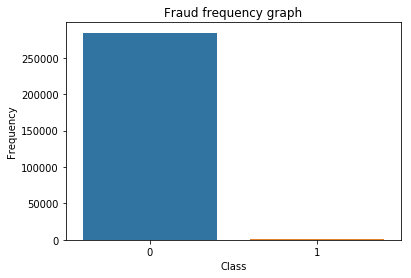

In [3]:
sns.barplot([0, 1], cc_df['Class'].value_counts())
plt.title("Fraud frequency graph")
plt.xlabel("Class")
plt.ylabel("Frequency")
cc_df['Class'].value_counts()

### Purchases by amount distribution

Here we can check the distribution of all purchases in our dataset.

/Users/mikael/Dev/datascience-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


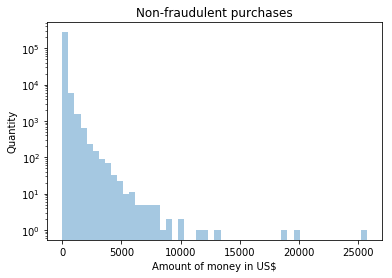

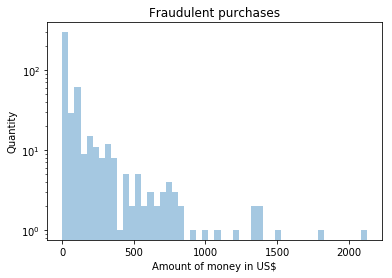

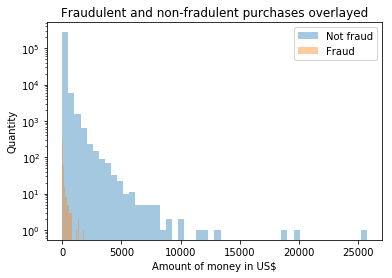

In [4]:
for i in range(2):
    sns.distplot(cc_df[cc_df.Class == i].Amount, hist_kws={'log':True}, kde=False)
    plt.title('{} purchases'.format('Non-fraudulent' if i == 0 else 'Fraudulent'))
    plt.ylabel('Quantity')
    plt.xlabel('Amount of money in US$')
    plt.show()

for i in range(2):
    sns.distplot(cc_df[cc_df.Class == i].Amount, hist_kws={'log':True}, kde=False)
    plt.title('Fraudulent and non-fradulent purchases overlayed')
    plt.ylabel('Quantity')
    plt.xlabel('Amount of money in US$')
    plt.legend(['Not fraud', 'Fraud'])
plt.show()

It's shown that most of these examples are low amount purchases. It's noticeable that most fraudulent purchases are low amount.

## Amount distribution through time

Here we can check that most credit card transactions are for buying inexpensive items.

Text(0.5,1,'Amount distribution through time')

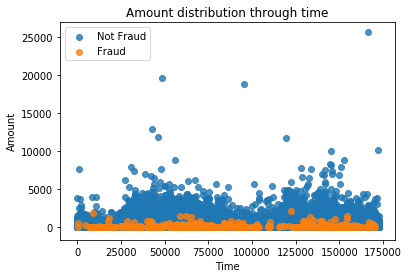

In [5]:
sns.regplot(cc_df[cc_df.Class == 0].Time, cc_df[cc_df.Class == 0].Amount, fit_reg=False)
sns.regplot(cc_df[cc_df.Class == 1].Time, cc_df[cc_df.Class == 1].Amount, fit_reg=False)
plt.legend(["Not Fraud", "Fraud"])
plt.title("Amount distribution through time")

### Plotting anonymized data

Here we can check how distributed are each feature in our dataset between fraud and non-fraud examples.

/Users/mikael/Dev/datascience-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


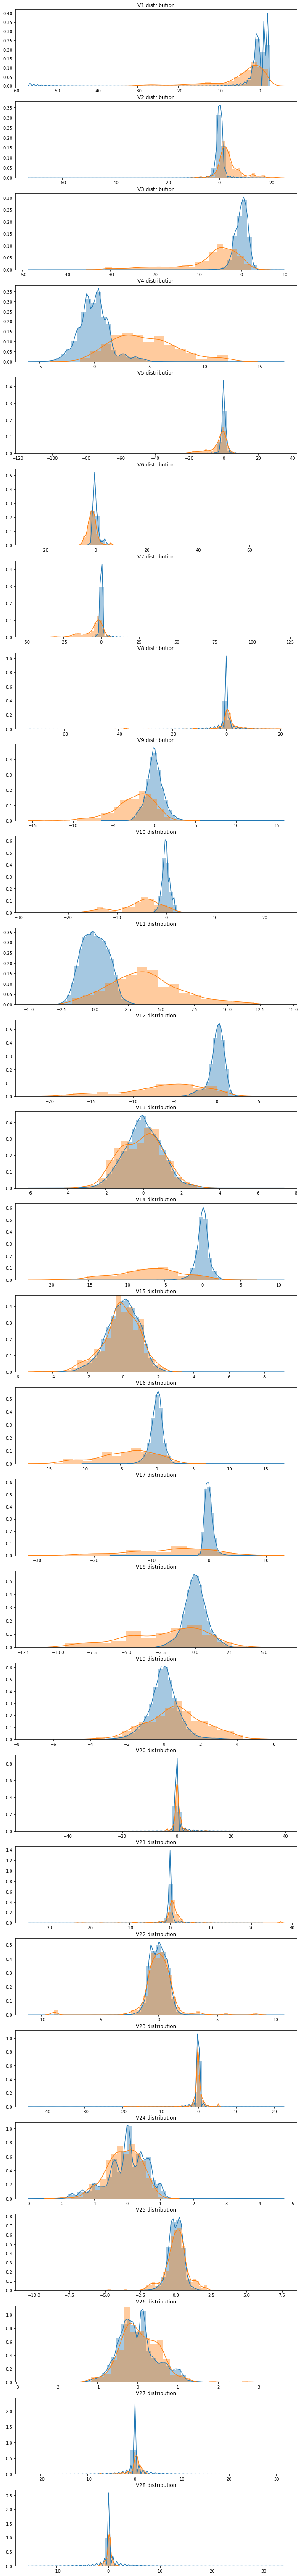

In [6]:
# Based on https://www.kaggle.com/currie32/predicting-fraud-with-tensorflow
anon_features = cc_df.iloc[:,1:29].columns

plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, feature in enumerate(anon_features):
    ax = plt.subplot(gs[i])
    sns.distplot(cc_df[feature][cc_df.Class == 0])
    sns.distplot(cc_df[feature][cc_df.Class == 1])
    plt.xlabel('')
    plt.title("{} distribution".format(feature))
plt.show()

As we can see, there are some features that contain different distributions between the fraudulent examples and the normal ones. This can be useful if we want to apply any feature engineering techniques. We'll be using Neural Networks later to tackle this example and they are known to work nicely using all data without any feature engineering, so I'll maintain our data as it is.

## Classifying using imbalanced data

I'll be trying to classify our data without any measure placed to help with the imbalanced data. It's expected that this classifier won't work very well in the real world, even if its accuracy is very high.

This happens because as most of our data belong to one class, our classifier learns that if it classifies most of the data as the majority class, it will predict correctly most of the time.

To show this problem I'll be using Decision Tree and Logistic Regression to classify our data as it is and see its recall and precision scores.

In [7]:
X = cc_df.drop(['Amount', 'Time', 'Class'], axis=1)
y = cc_df['Class']

In [8]:
dtc = DecisionTreeClassifier(random_state=0)
lrc = LogisticRegression(random_state=0)

In [9]:
cv_scores_dtc = cross_validate(dtc, X, y, cv=10, scoring=['recall', 'precision', 'accuracy'], n_jobs=-1, return_train_score=False)
cv_scores_lrc = cross_validate(lrc, X, y, cv=10, scoring=['recall', 'precision', 'accuracy'], n_jobs=-1, return_train_score=False)
y_pred_dtc = cross_val_predict(dtc, X=X, y=y, cv=10, n_jobs=-1)
y_pred_lrc = cross_val_predict(lrc, X=X, y=y, cv=10, n_jobs=-1)

##### Metrics for decision tree classifier

Mean Accuracy: 0.9986938523280677
Accuracy: [0.9982094  0.99880626 0.99943822 0.99943822 0.99926267 0.99592697
 0.99891152 0.99894663 0.99908708 0.99891152]

Mean precision: 0.6003344481605352
Precision: [0.49438202 0.72222222 0.82352941 0.94594595 0.85       0.25547445
 0.63636364 0.68627451 0.75555556 0.69565217]

Mean recall: 0.7296747967479674
Recall: [0.88       0.52       0.85714286 0.71428571 0.69387755 0.71428571
 0.85714286 0.71428571 0.69387755 0.65306122]

Normalized confusion matrix
[[9.99159383e-01 8.40616921e-04]
 [2.70325203e-01 7.29674797e-01]]


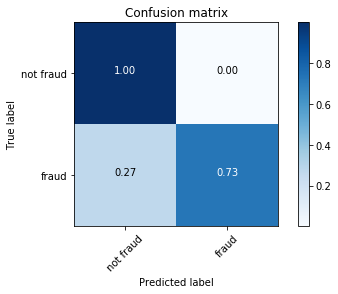

In [15]:
recall, precision, accuracy = cv_scores_dtc['test_recall'], cv_scores_dtc['test_precision'], cv_scores_dtc['test_accuracy']

print("Mean Accuracy: {}".format(accuracy_score(y, y_pred_dtc)))
print("Accuracy: {}\n".format(accuracy))

print("Mean precision: {}".format(precision_score(y, y_pred_dtc)))
print("Precision: {}\n".format(precision))

print("Mean recall: {}".format(recall_score(y, y_pred_dtc)))
print("Recall: {}\n".format(recall))

cm = confusion_matrix(y_pred=y_pred_dtc, y_true=y)
futils.plot_confusion_matrix(cm, classes=['not fraud', 'fraud'], normalize=True)

##### Metrics for logistic regression classifier

Mean Accuracy: 0.9986938523280677
Accuracy: [0.9982094  0.99880626 0.99943822 0.99943822 0.99926267 0.99592697
 0.99891152 0.99894663 0.99908708 0.99891152]

Mean precision: 0.6003344481605352
Precision: [0.49438202 0.72222222 0.82352941 0.94594595 0.85       0.25547445
 0.63636364 0.68627451 0.75555556 0.69565217]

Mean recall: 0.7296747967479674
Recall: [0.88       0.34       0.85714286 0.40816327 0.36734694 0.51020408
 0.83673469 0.51020408 0.55102041 0.53061224]

Normalized confusion matrix
[[9.99838208e-01 1.61792378e-04]
 [4.20731707e-01 5.79268293e-01]]


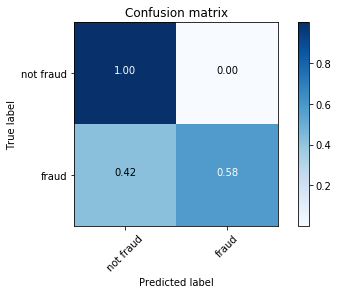

In [19]:
recall, precision, accuracy = cv_scores_lrc['test_recall'], cv_scores_dtc['test_precision'], cv_scores_dtc['test_accuracy']

print("Mean Accuracy: {}".format(accuracy_score(y, y_pred_dtc)))
print("Accuracy: {}\n".format(accuracy))

print("Mean precision: {}".format(precision_score(y, y_pred_dtc)))
print("Precision: {}\n".format(precision))

print("Mean recall: {}".format(recall_score(y, y_pred_dtc)))
print("Recall: {}\n".format(recall))

cm = confusion_matrix(y_pred=y_pred_lrc, y_true=y)
futils.plot_confusion_matrix(cm, classes=['not fraud', 'fraud'], normalize=True)

We can see the model is bad because, while it does have a high test accuracy, its recall and precision are low. That's happening because the data given to the model is highly imbalanced, so the model learns to predict the highest class in the training data.

I'll be exploring ways to solve this problem in the next notebook.